# LangGraph Agents

LangGraph is a special LangChain-built library that focuses on building intelligent AI Agents using graphs. Ie, agentic state machines.

We need these prerequisite libraries to run a graph visualization library (`pygraphviz`). We will use this library during this notebook to understand the structure of our graphs _but_ it is not required to use `langgraph`.

In [1]:
!apt-get install graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jamm

Now we install Python libraries:

In [2]:
!pip install -qU \
    langchain-pinecone==0.1.0 \
    langchain-openai==0.1.3 \
    langchain==0.1.16 \
    langchain-core==0.1.42 \
    langgraph==0.0.37 \
    langchainhub==0.1.15 \
    pygraphviz==1.12  # for visualizing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
     ━━

## Setup Knowledge Base

We'll be running our agent against a knowledge base — which requires a Pinecone index to be built.

You can, if needed, skip this step and replace the `search` tool with a placeholder value if wanting to quickly test the structure of a RAG agent _without_ the RAG.

If you want full functionality here, you do need to run this section — but we'll make it quick.

### Download a Dataset

The first thing we need for an agent using RAG is somewhere we want to pull knowledge from. We will use v2 of the AI ArXiv dataset, available on Hugging Face Datasets at [`jamescalam/ai-arxiv2-chunks`](https://huggingface.co/datasets/jamescalam/ai-arxiv2-chunks).

Note: we're using the prechunked dataset. For the raw version see [`jamescalam/ai-arxiv2`](https://huggingface.co/datasets/jamescalam/ai-arxiv2).

## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Custom Tools

We will define two tools for this agent, a `search` tool and a `final_answer` tool — which is our structured output.

In [ ]:
from langchain_core.tools import tool

@tool("search", return_direct=True)
def search_tool(query: str):
    """Finds information using a natural language query."""
    print("hit search tool")
    return "Dogs are better than cats"

@tool("final_answer", return_direct=True)
def final_answer_tool(
    answer: str,
    source: str
):
    """Returns a natural language response to the user in `answer`,
    and a `source` which provides a short
    summary of any information used to provide this answer.
    """
    print("hit structured_output tool")
    return ""

In [ ]:
final_answer_tool

StructuredTool(name='final_answer', description='final_answer(answer: str, source: str) - Returns a natural language response to the user in `answer`,\n    and a `source` which provides a short\n    summary of any information used to provide this answer.', args_schema=<class 'pydantic.v1.main.final_answerSchema'>, return_direct=True, func=<function final_answer_tool at 0x78c6d1d55240>)

## Initialize Agent

In [ ]:
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key="sk-...",
    temperature=0,
    streaming=True
)

prompt = hub.pull("hwchase17/openai-functions-agent")

oracle_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[final_answer_tool, search_tool],
    prompt=prompt
)

Test the agent quickly to confirm it is functional:

In [ ]:
inputs = {
    "input": "tell me something interesting about dogs",
    "chat_history": [],
    "intermediate_steps": []
}
agent_out = oracle_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='search', tool_input={'query': 'interesting facts about dogs'}, log="\nInvoking: `search` with `{'query': 'interesting facts about dogs'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_6iDz57J34lzCGsApb6rDwgbu', 'function': {'arguments': '{"query":"interesting facts about dogs"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-c5b02231-b72f-427f-9a12-20fbae8d80fb-0', tool_calls=[{'name': 'search', 'args': {'query': 'interesting facts about dogs'}, 'id': 'call_6iDz57J34lzCGsApb6rDwgbu'}])], tool_call_id='call_6iDz57J34lzCGsApb6rDwgbu')]

In [ ]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'index': 0,
 'id': 'call_6iDz57J34lzCGsApb6rDwgbu',
 'function': {'arguments': '{"query":"interesting facts about dogs"}',
  'name': 'search'},
 'type': 'function'}

We would use this information to route our state to either the `search` or `final_answer` nodes of our graph.

## Define Nodes for Graph

In [ ]:
from langchain_core.agents import AgentFinish
import json

def run_oracle(state: list):
    print("run_oracle")
    agent_out = oracle_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    return {"intermediate_steps": [{"search": str(out)}]}

def router(state: list):  # ASHRAQ
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"

# finally, we will have a single LLM call that MUST use structured output
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

def final_answer(state: list):
    print("final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

def handle_error(state: list):   # ASHRAQ
    print("handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

## Define Graph

In [ ]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)  # ASHRAQ
graph.add_node("final_answer_aggregator", final_answer)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    start_key="oracle",  # where in graph to start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "search": "search",
        "error": "error",  # ASHRAQ
        "final_answer": END
    }
)
graph.add_edge("search", "final_answer_aggregator")
graph.add_edge("error", END)  # ASHRAQ
graph.add_edge("final_answer_aggregator", END)

runnable = graph.compile()

In [ ]:
from langchain_core.messages import HumanMessage

runnable = graph.compile()

out = runnable.invoke({
    "input": "tell me something interesting about dogs",
    "chat_history": []
})

run_oracle
run_oracle: [ToolAgentAction(tool='search', tool_input={'query': 'interesting facts about dogs'}, log="\nInvoking: `search` with `{'query': 'interesting facts about dogs'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_pQsdynLNSRYDPbZ0sFUTODr0', 'function': {'arguments': '{"query":"interesting facts about dogs"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-28820060-d59f-4e0c-830d-beba0c8fcf3f-0', tool_calls=[{'name': 'search', 'args': {'query': 'interesting facts about dogs'}, 'id': 'call_pQsdynLNSRYDPbZ0sFUTODr0'}])], tool_call_id='call_pQsdynLNSRYDPbZ0sFUTODr0')]
execute_search
hit search tool
final_answer


In [ ]:
print(out["agent_out"])

{"answer":"Dogs have an incredible sense of smell and can detect certain diseases in humans, such as cancer and diabetes, through their keen sense of smell.","source":"Dogs are better than cats"}


In [ ]:
out = runnable.invoke({
    "input": "hi",
    "chat_history": []
})

run_oracle
run_oracle: return_values={'output': 'Hello! How can I assist you today?'} log='Hello! How can I assist you today?'
handle_error


In [ ]:
print(out["agent_out"])

{"answer":"Hello! How can I assist you today?","source":"User greeted the assistant"}


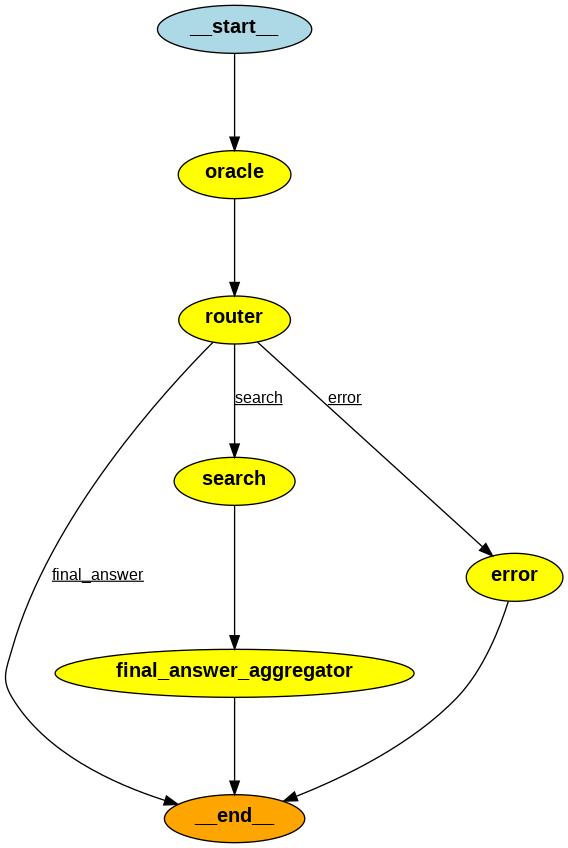

In [ ]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())